<a href="https://colab.research.google.com/github/visiont3lab/mask-detector-covid/blob/main/notebooks/Project_Covid_Mask_Classifier_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Project Part3: Mask-NoMask Classifier

## Setup

In [1]:
# Scaricare il repositorio da github per avere accesso alle immagini
!git clone https://github.com/visiont3lab/mask-detector-covid.git

fatal: destination path 'mask-detector-covid' already exists and is not an empty directory.


## Data Augumentation

In [2]:
!rm -rf mask-detector-covid/dataset-aug
!mkdir -p mask-detector-covid/dataset-aug/mask
!mkdir -p mask-detector-covid/dataset-aug/no-mask

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import cv2
import os

try:
  os.makedirs("mask-detector-covid/dataset-aug/mask")
  os.makedirs("mask-detector-covid/dataset-aug/no-mask")
except:
  print("Unable to create folder")

images_generator = ImageDataGenerator(
        brightness_range=(0.2, 1.5),
        horizontal_flip=True,
        width_shift_range=0.12,
        height_shift_range=0.12,
        rotation_range=10, #2,
        zoom_range=0.15
        ).flow_from_directory(
            directory="mask-detector-covid/dataset/",
            classes=["mask","no-mask"],
            target_size=(64,64),
            color_mode="rgb", # grayscale
            batch_size=10,
            class_mode="categorical",
            shuffle=True,
            seed=42
        )

#images_aug_batch,_ = images_generator.next()
l = ["mask","no-mask"]
k = 0
for m in range(0,130):
  x, y = images_generator.next()
  for i in range(0, x.shape[0]):
    #display(Image.fromarray(np.uint8(x[i])))
    if l[np.argmax(y[i])] == "mask":
      cv2.imwrite("mask-detector-covid/dataset-aug/mask/"+str(k) + ".png", np.uint8(x[i]))
    else:
     cv2.imwrite("mask-detector-covid/dataset-aug/no-mask/"+str(k) + ".png", np.uint8(x[i]))
    k = k +1
  #break

#0     1
#mask no-mask
#1     0

# --- softmax --> "mask","no-mask"


Unable to create folder
Found 999 images belonging to 2 classes.


## Read Data

In [4]:
import os
import cv2
from PIL import Image
import numpy as np


# ritorna i nomi dei file contenuti nella cartella --> li ritorna come listaù
directory_path_mask = "mask-detector-covid/dataset-aug/mask"
directory_path_nomask = "mask-detector-covid/dataset-aug/no-mask"

# Dati finali
X = []
Y = []

def preprocess(filepath):

  # Read Image
  # im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED) # 0-255  unit8 -- unint16
  im = cv2.imread(filepath, cv2.IMREAD_COLOR) # 0-255  unit8 -- unint16
  
  # Conver to RGB
  im =cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  # Conversione da RGB a Bianco e nero
  #im =cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

  # Colora un immagine in bianco e nero con una colormap
  #im = cv2.applyColorMap(im, cv2.COLORMAP_JET);

  # La colormap e BGR convertila a RGB per visualizzazione correta
  #im =cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  # Resize Immagine
  im = cv2.resize(im, (64,64))
  #print(im.shape)

  return im

# Importante che le cartelle mask e no mask contengano lo stesso numero di immagini 
for name_mask, name_nomask in zip(os.listdir(directory_path_mask)[0:] , os.listdir(directory_path_nomask)[0:]):

  # Get filepath (path completo) dell' immagine
  filepath_mask = os.path.join(directory_path_mask,name_mask)
  filepath_nomask = os.path.join(directory_path_nomask,name_nomask)
  #filepath = directory_path + "/" + name

  im_mask = preprocess(filepath_mask)
  im_nomask = preprocess(filepath_nomask)

  xdata_mask = im_mask.reshape(-1)
  xdata_nomask = im_nomask.reshape(-1)
  
  X.append(xdata_mask)
  X.append(xdata_nomask)
  Y.append(0)
  Y.append(1)
  
  # numpy array --> Immagine PIL --> RGB
  #display(Image.fromarray(im_mask))
  #display(Image.fromarray(im_nomask))
  
  #break

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print(X.shape, Y.shape)

(1278, 12288) (1278,)


## Compare models

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,f1_score

def compare_models(X,Y):

  # Model selection
  models = {}
  models["GradientBoostingClassifier"]    = GradientBoostingClassifier() #n_estimators=50)
  models["RandomForestClassifier"]        = RandomForestClassifier() #n_estimators=100)
  models["GaussianNB"]                    = GaussianNB()
  #models["LogisticRegression"]            = LogisticRegression()
  models["SVC"]                           = SVC(probability=True)
  models["KNeighborsClassifier"]          = KNeighborsClassifier(n_neighbors=3)

  # Cross validation
  k_fold  = KFold(n_splits=5, random_state=5,shuffle=True)

  model_results = []
  model_names   = []
  for name in list(models.keys()):
    
    # Definisco il modello
    pipe = Pipeline([
        ("normalize", MinMaxScaler(feature_range=(0,1))), 
        ("pca", PCA(0.99)), 
        (name, models[name]) # trovare i parametri a0 a1 a2 
    ])

    # Cross validation
    c = 0 
    results = []
    for train_index, test_index in k_fold.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train = X[train_index]
      y_train = Y[train_index]
      X_test = X[test_index]
      y_test = Y[test_index]

      pipe.fit(X_train,y_train)
      y_test_hat = pipe.predict(X_test)

      # Error
      #err = precision_score(y_test,y_test_hat)
      #err = recall_score(y_test,y_test_hat)
      #err = accuracy_score(y_test,y_test_hat)
      err = f1_score(y_test,y_test_hat,average="weighted")

      results.append(err)

      print(name + ": fold number: "+ str(c) + " --> F1score: ", np.round(err,3))
      c = c+1
    
    print("{}: {}, {}".format(name, round(np.array(results).mean(), 3), round(np.round(results).std(), 3)))

    model_results.append(results)
    model_names.append(name)
  return model_names, model_results
    
model_names, model_results = compare_models(X,Y)

GradientBoostingClassifier: fold number: 0 --> F1score:  0.898
GradientBoostingClassifier: fold number: 1 --> F1score:  0.922
GradientBoostingClassifier: fold number: 2 --> F1score:  0.934
GradientBoostingClassifier: fold number: 3 --> F1score:  0.921
GradientBoostingClassifier: fold number: 4 --> F1score:  0.941
GradientBoostingClassifier: 0.923, 0.0
RandomForestClassifier: fold number: 0 --> F1score:  0.879
RandomForestClassifier: fold number: 1 --> F1score:  0.859
RandomForestClassifier: fold number: 2 --> F1score:  0.848
RandomForestClassifier: fold number: 3 --> F1score:  0.816
RandomForestClassifier: fold number: 4 --> F1score:  0.878
RandomForestClassifier: 0.856, 0.0
GaussianNB: fold number: 0 --> F1score:  0.574
GaussianNB: fold number: 1 --> F1score:  0.635
GaussianNB: fold number: 2 --> F1score:  0.6
GaussianNB: fold number: 3 --> F1score:  0.593
GaussianNB: fold number: 4 --> F1score:  0.581
GaussianNB: 0.597, 0.0
SVC: fold number: 0 --> F1score:  0.93
SVC: fold number: 1 -

In [6]:
import plotly.graph_objects as go

# Visualize results
fig = go.Figure()
for name,res in zip(model_names,model_results):    
    fig.add_trace(go.Box(y=res,name=name, boxpoints='all'))
fig.show()

## Training

In [7]:
from sklearn.model_selection import train_test_split
# Train e test data
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.10,shuffle=True, random_state=25)

In [8]:
from sklearn.preprocessing import  MinMaxScaler  
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import precision_score,recall_score, accuracy_score, f1_score
from sklearn.decomposition import PCA
import pickle
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

pipe = Pipeline([
    ("normalize", MinMaxScaler(feature_range=(0,1))), 
    ("pca", PCA(0.99)), 
    #("model", LinearSVC(C=10, loss="hinge")
    ("model", SVC(C=10,probability=True))
    #("model", SVC(kernel="poly",degree=3,C=0.50, coef0=0.5)) # Kernel Trick
    #("model", SVC(kernel="rbf",gamma=1,C=10)) # Kernel Trick # gamma=5, gamma=0.1, C=1000 , C=0.001
])


tuned_parameters = [
          {'model__kernel': ['rbf'],  'model__C': [10, 100]},
          #{'model__kernel': ['linear'], 'model__C': [1, 10, 100, 1000]},
          #{'model__kernel' : ['poly'], 'model__degree' : [2,3,4] ,'model__C': [1,10, 100, 1000]}
      ]

grid_search = RandomizedSearchCV(
  pipe, tuned_parameters, scoring='f1_macro'
)

# Train
grid_search.fit(X_train,y_train)

# Score
score = grid_search.best_estimator_.score(X,Y)

print("f1_weighted score : ", score)

model = grid_search.best_estimator_

y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

# Save 
with open("model.pkl", 'wb') as f:
    pickle.dump(model, f) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.



f1_weighted score :  0.9898278560250391


In [9]:
precision = precision_score(y_test,y_test_hat)
recall = recall_score(y_test,y_test_hat)
accuracy = accuracy_score(y_test,y_test_hat)
f1 = f1_score(y_test,y_test_hat,average="weighted")
print("precision:", precision)
print("recall:", recall)
print("accuracy:", accuracy)
print("f1:", f1)


precision: 0.971830985915493
recall: 0.9857142857142858
accuracy: 0.9765625
f1: 0.9765437095282146


In [10]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 0  mask  1 senza
cm_train = confusion_matrix(y_train,y_train_hat)
cm_test = confusion_matrix(y_test,y_test_hat)
df_train = pd.DataFrame(cm_train, columns=["Pred-Mask","Pred-No-Mask"], index=["Real-Mask","Real-No-Mask"])
df_test = pd.DataFrame(cm_test, columns=["Pred-Mask","Pred-No-Mask"], index=["Real-Mask","Real-No-Mask"])
print("TRAIN")
display(df_train)
print("TEST")
display(df_test)

TRAIN


,Pred-Mask,Pred-No-Mask
Real-Mask,571,10
Real-No-Mask,0,569


TEST


,Pred-Mask,Pred-No-Mask
Real-Mask,56,2
Real-No-Mask,1,69


| Risultato Esatto   | Risulato Predetto |  |
|------------|---------------------------|--|
|            |   Negativo | Positivo |
|Negativo    |    TN=97750     |    FP=150    |
|Positivo    |    FN=330      |    TP=1770    |



* Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$

* Recall = $\frac{TP}{TP+FN}$

* Precision = $\frac{TP}{TP+FP}$

* F1 = $\frac{2*Precision*recall}{Precision+Recall}$

## Test trained Model

In [11]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


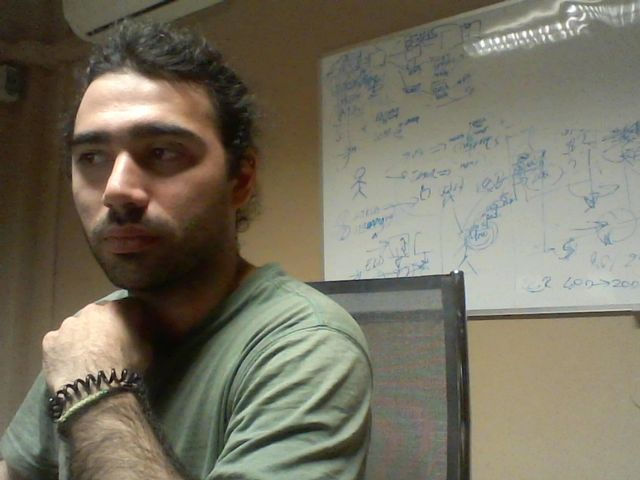

In [12]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(1, 12288)


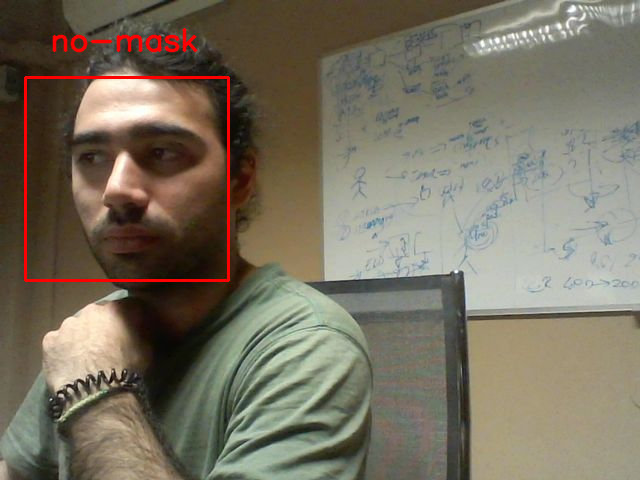

In [13]:
import cv2
from PIL import Image
import numpy as np
import pickle

def  findLargestBB(bbs):
  areas = [w*h for x,y,w,h in bbs]
  if not areas:
      return False, None
  else:
      i_biggest = np.argmax(areas) 
      biggest = bbs[i_biggest]
      return True, biggest

# Load face detector
model_face = cv2.CascadeClassifier('mask-detector-covid/models/haar-cascade-files/haarcascade_frontalface_default.xml')

# Load mask classifier
with open("model.pkl", 'rb') as f:
  model_mask = pickle.load(f)

class_names = ["mask", "no-mask"]
# Carichiamo l'immagina
frame = cv2.imread("photo.jpg")
# coversione immagine da BGR a RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Trova tutte le facce nell'immagine
faces = model_face.detectMultiScale(frame,scaleFactor=1.05,minNeighbors=4, flags=cv2.CASCADE_DO_ROUGH_SEARCH | cv2.CASCADE_SCALE_IMAGE)

# Trova la faccia piu grande (area piu grande)
ret, facebig = findLargestBB(faces)

# Per ogni faccia fai qualcosa
if ret == True:

  # Extra coordiante of largest image
  x,y,w,h = facebig
  
  # Crop image 
  roi = frame[y:y+h,x:x+w]

  # -----
  # 64x64x3 --> messe su una linea
  roi = cv2.resize(roi,(64,64))
  inpX = roi.reshape(1,-1)
  print(inpX.shape)
  y_hat = model_mask.predict(inpX)
  cv2.putText(frame, class_names[int(y_hat[0])], (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
  # -----

  # Disegna il quadrato
  cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

  # In colab o jupyter
  im_roi = Image.fromarray(roi)
  im_full = Image.fromarray(frame)
  
  display(im_full)
  #display(im_roi)
